# Intro to using `naturf` 

In [1]:
import geopandas as gpd
import math
import matplotlib as pyplot
import numpy as np
import naturf.nodes
import pandas as pd

from naturf.config import Settings

In [2]:
PIXEL_SIZE = 0.5
path = "example/shapefile/C-5.shp"
gdf = gpd.read_file(path)
gdf = naturf.nodes.standardize_column_names_df(gdf)
gdf = naturf.nodes.filter_zero_height_df(gdf)
gdf = naturf.nodes.apply_max_building_height(gdf)

In [3]:
gdf[Settings.area_field] = naturf.nodes.building_area(gdf[Settings.geometry_field])
gdf["total_plan_area_geometry"] = naturf.nodes.total_plan_area_geometry(gdf[Settings.geometry_field])

In [4]:
# merge wall_length into buildings_intersecting_plan_area
gdf = pd.concat([gdf, naturf.nodes.wall_length(naturf.nodes.wall_angle_direction_length(gdf.geometry))], axis=1)

In [5]:
buildings_intersecting_plan_area = naturf.nodes.buildings_intersecting_plan_area(
    gdf.building_id,
    gdf.building_height,
    gdf[Settings.geometry_field],
    gdf.building_area,
    naturf.nodes.total_plan_area_geometry(gdf[Settings.geometry_field]),
    gdf[Settings.wall_length_north],
    gdf[Settings.wall_length_east],
    gdf[Settings.wall_length_south],
    gdf[Settings.wall_length_west],
    naturf.nodes.target_crs(gdf),
)
gdf[Settings.building_plan_area_field] = naturf.nodes.building_plan_area(buildings_intersecting_plan_area)

In [6]:
gdf[Settings.grimmond_oke_displacement_height] = naturf.nodes.grimmond_oke_displacement_height(gdf[Settings.height_field])
gdf[Settings.grimmond_oke_roughness_length] = naturf.nodes.grimmond_oke_roughness_length(gdf[Settings.height_field])

In [7]:
buildings_intersecting_plan_area["building_centroid_target"] = naturf.nodes.building_centroid_target(buildings_intersecting_plan_area[Settings.geometry_field], naturf.nodes.target_crs(buildings_intersecting_plan_area))
buildings_intersecting_plan_area["building_centroid_neighbor"] = naturf.nodes.building_centroid_neighbor(buildings_intersecting_plan_area["building_geometry_neighbor"], naturf.nodes.target_crs(gdf))
buildings_intersecting_plan_area["distance_to_neighbor_by_centroid"] = naturf.nodes.distance_to_neighbor_by_centroid(buildings_intersecting_plan_area["building_centroid_target"], buildings_intersecting_plan_area["building_centroid_neighbor"])

In [8]:
# add average distance between buildings
gdf = gdf.merge(naturf.nodes.average_distance_between_buildings(buildings_intersecting_plan_area[Settings.target_id_field], buildings_intersecting_plan_area[Settings.distance_to_neighbor_by_centroid]), how="left", on=Settings.id_field)

gdf[Settings.sky_view_factor] = naturf.nodes.sky_view_factor(gdf[Settings.height_field], gdf.average_distance_between_buildings)

In [9]:
# merge in frontal area density
gdf = pd.concat([gdf, naturf.nodes.frontal_area_density(naturf.nodes.frontal_length(buildings_intersecting_plan_area), gdf.building_height)], axis=1)

<Axes: >

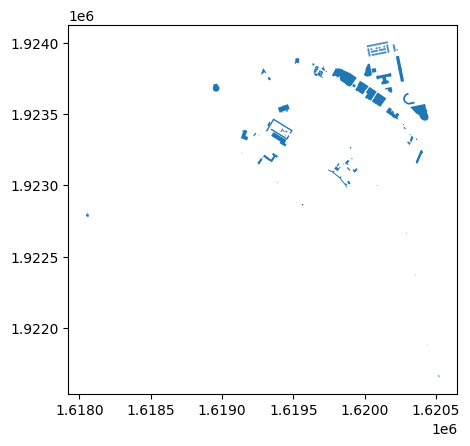

In [10]:
gdf.plot()

In [11]:
gdf

,Join_Count,TARGET_FID,FID_1,building_id,GIS_ID,FEATURECOD,DESCRIPTIO,CAPTUREYEA,CAPTUREACT,SHAPE_Leng,...,frontal_area_west_5,frontal_area_west_6,frontal_area_west_7,frontal_area_west_8,frontal_area_west_9,frontal_area_west_10,frontal_area_west_11,frontal_area_west_12,frontal_area_west_13,frontal_area_west_14
0,1,132230,132229,132230,NaN,BUILDING,Building,2017-03-09T00:00:00.000Z,Update,88.360518,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
1,1,132237,132236,132237,NaN,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,23.649351,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
2,2,132338,132337,132338,NaN,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,404.280929,...,1038.741417,0.00000,0.00000,0,0,0,0,0,0,0
3,1,134281,134280,134281,NaN,BUILDING,Building,2017-03-09T00:00:00.000Z,Add,516.345080,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
4,1,134322,134321,134322,NaN,BUILDING,Building,2017-03-09T00:00:00.000Z,Add,302.001260,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1,159784,159783,159784,NaN,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,10.255482,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
188,1,159785,159784,159785,NaN,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,10.295296,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
189,1,159801,159800,159801,NaN,BUILDING,Building,2015-04-24T00:00:00.000Z,Existing,9.847711,...,0.000000,0.00000,0.00000,0,0,0,0,0,0,0
190,1,159991,159990,159991,NaN,MEMORIAL,Memorial,2015-04-24T00:00:00.000Z,Existing,169.791410,...,233.971650,233.97165,185.77349,0,0,0,0,0,0,0
